In [1]:
from ESDIRK23 import ESDIRK23_solver
from DP54 import DP54_solver
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
import numba
from matplotlib.gridspec import GridSpec

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')  
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.fontsize'] = 13

In [3]:
t_range = np.array((0.0, 2000.0))
h_size = np.array((1e-6 ,1e1))
x0 = np.array((2.0, 0.0, 0.0))
argv = np.array((1000.0, )) # argv[0] is mu in van der pol
reps = 1e-6
aeps = 1e-8
model = 1 # 1 is van der pol model
MAX_STEPS = int(5000)
t_history, x_history, t_adaptive_size, t_adaptive = ESDIRK23_solver(x0, argv, t_range, h_size, reps, aeps, model, MAX_STEPS)

Time: 0.001285 seconds
step size number is: 4506


In [4]:
x_history_1 = x_history[:, 0]
x_history_2 = x_history[:, 1]

In [5]:
def vanderpol(t, y, mu):
    # y = [x, x']
    return np.array([y[1],
                     mu * (1. - y[0]**2) * y[1] - y[0]])

def vanderpol_jac(t, y, mu):
    # dy_i / dy_j
    return np.array([[ 0.0,                              1.0],
                     [-2*mu*y[0]*y[1] - 1.0,  mu*(1. - y[0]**2) ]])

t_span = (0.0, 2000.0)
y0 = np.array([2.0, 0.0])
mu = 1000.0
rtol = 1e-6
atol = 1e-8
h_min = 1e-6            # first_step
h_max = 1e0 * 100        # max_step

tic = time.time()
sol = solve_ivp(fun  = lambda t, y: vanderpol(t, y, mu),
                t_span     = t_span,
                y0         = y0,
                method     = 'Radau',          
                jac        = lambda t, y: vanderpol_jac(t, y, mu),
                rtol       = rtol,
                atol       = atol,
                first_step = h_min,
                max_step   = h_max,
                dense_output=False)          
toc = time.time() - tic

print(f"SciPy Radau finished, n_step = {sol.nfev}, elapsed = {toc:.4f} s")
print("status:", sol.message)

t_history_scipy     = sol.t
x_history_1_scipy   = sol.y[0]      
x_history_2_scipy   = sol.y[1]      
step_sizes = np.diff(sol.t)



SciPy Radau finished, n_step = 6689, elapsed = 0.0509 s
status: The solver successfully reached the end of the integration interval.


In [6]:
t_range = np.array((0.0, 2000.0))
h_size = np.array((1e-6 ,1e-2))
x0 = np.array((2.0, 0.0, 0.0))
argv = np.array((1000.0, )) # argv[0] is mu in van der pol
reps = 1e-6
aeps = 1e-8
num_var = np.size(x0)
model = 1 # 1 is van der pol model
MAX_STEPS = int(1161262)
t_history2, x_history2, t_adaptive_size2, t_adaptive2 = DP54_solver(x0, argv, t_range, h_size, reps, aeps, model, MAX_STEPS)
x_history_12 = x_history2[:, 0]
x_history_22 = x_history2[:, 1]

Time: 0.073048 seconds
step size number is: 1161261


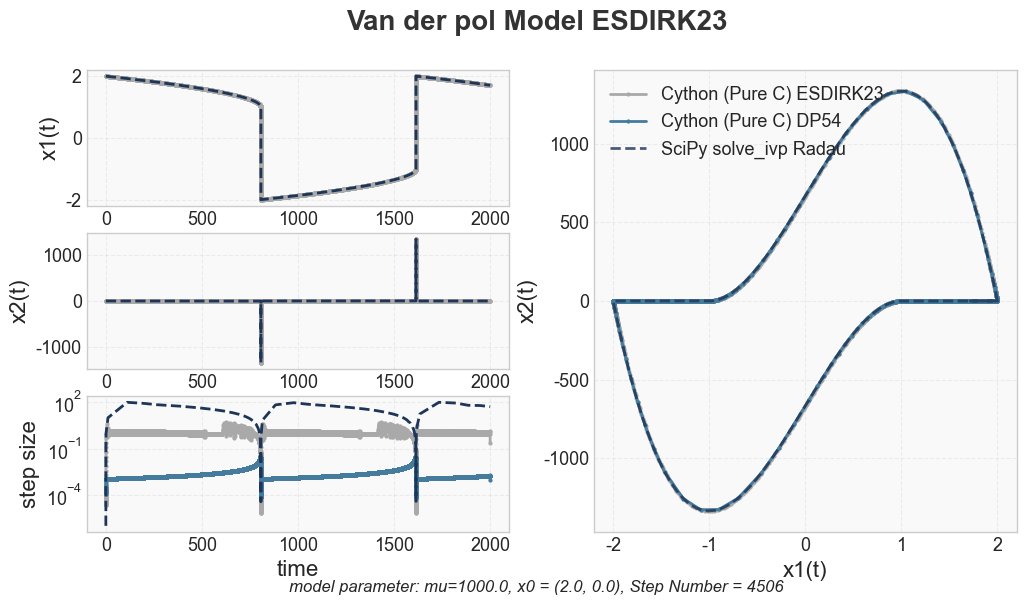

In [7]:
fig = plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid') 
gs = GridSpec(3, 2, figure=fig)
pic1 = fig.add_subplot(gs[0, 0])
pic2 = fig.add_subplot(gs[1, 0])
pic4 = fig.add_subplot(gs[2, 0])
pic3 = fig.add_subplot(gs[:, 1])
pic1.plot(t_history, x_history_1, '#A9A9A9', linewidth=2, markersize=4, marker='.', label=f'mu = {argv[0]}', alpha=1)    
pic2.plot(t_history, x_history_2, '#A9A9A9', linewidth=2, markersize=4, marker='.', label=f'mu = {argv[0]}', alpha=1) 
pic1.plot(t_history_scipy, x_history_1_scipy, '#1D3557', linewidth=2, markersize=4, alpha=1, linestyle='--')    
pic2.plot(t_history_scipy, x_history_2_scipy, '#1D3557', linewidth=2, markersize=4, alpha=1, linestyle='--') 
pic3.plot(x_history_1, x_history_2, '#A9A9A9', linewidth=2, marker='.', markersize=4, label=f'Cython (Pure C) ESDIRK23', alpha=1)    
pic3.plot(x_history_12, x_history_22, '#457B9D', linewidth=2, marker='.', markersize=4, label=f'Cython (Pure C) DP54', alpha=1)   
pic4.plot(t_adaptive, t_adaptive_size, '#A9A9A9', linewidth=2, marker='.', markersize=4, label=f'mu = {argv[0]}', alpha=1)  
pic4.plot(t_adaptive2, t_adaptive_size2, '#457B9D', linewidth=2, marker='.', markersize=4, label=f'mu = {argv[0]}', alpha=1)  
pic4.plot(t_history_scipy[1:], step_sizes, '#1D3557', linewidth=2, markersize=4, alpha=1, linestyle='--')  
pic3.plot(x_history_1_scipy, x_history_2_scipy, '#1D3557', linewidth=2, markersize=4, label=f'SciPy solve_ivp Radau', alpha=0.8, linestyle='--')   
pic4.set_yscale('log')  
pic1.set_ylabel('x1(t)')
pic2.set_ylabel('x2(t)')
pic4.set_xlabel('time')
pic4.set_ylabel('step size')
pic2.grid(True, which="both", ls="--", alpha=0.3)
pic4.grid(True, which="both", ls="--", alpha=0.3)
pic1.grid(True, which="both", ls="--", alpha=0.3)
pic3.set_xlabel('x1(t)')
pic3.set_ylabel('x2(t)')
pic3.grid(True, which="both", ls="--", alpha=0.3)
pic3.legend(loc='upper left') 
pic1.set_facecolor('#f9f9f9')
pic2.set_facecolor('#f9f9f9')
pic3.set_facecolor('#f9f9f9')
pic4.set_facecolor('#f9f9f9')

#fig.suptitle('Prey-Predator Model ', fontsize=18, fontweight='bold')
fig.suptitle('Van der pol Model ESDIRK23', fontsize=20, fontweight='bold', color='#333333', y=0.98)
fig.text(0.5, 0.01, f'model parameter: mu={argv[0]}, x0 = {x0[0], x0[1]}, Step Number = {t_history.shape[0]}', ha='center', fontsize=12, style='italic')
fig.savefig("ESDIRK23_van.png")